In [70]:
import os
import lightning as L
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch import optim, nn, utils
import torch

In [89]:
# define encoder
encoder = nn.Sequential(
    nn.Linear(in_features=28*28, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=32)
)

In [90]:
# define decoder
decoder = nn.Sequential(
    nn.Linear(in_features=32, out_features=64),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=28*28)
)

In [91]:
# define lightning class
class AutoEncoder(L.LightningModule):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def training_step(self, batch, batch_idx):
        x, y = batch
        x = x.view(x.size(0), -1)
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = nn.functional.mse_loss(x_hat, x)
        self.log("train_loss", loss)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [92]:
# instantiate lightning object
autoenc = AutoEncoder(encoder, decoder)

In [93]:
# load MNIST dataset
dataset = MNIST(root="./mnist", download=True, transform=ToTensor())

In [94]:
# load data in data loader
train_dataloader = utils.data.DataLoader(dataset, batch_size=64)

In [95]:
# create trainer
trainer = L.Trainer(max_epochs=50)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [96]:
# rock n roll
trainer.fit(model=autoenc, train_dataloaders=train_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 52.3 K | train
1 | decoder | Sequential | 53.1 K | train
-----------------------------------------------
105 K     Trainable params
0         Non-trainable params
105 K     Total params
0.422     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Training: |                                                                                                   …

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter serve

In [133]:
# predict
checkpoint = "./lightning_logs/version_20/checkpoints/epoch=49-step=46900.ckpt"
auto_enc_predictor = AutoEncoder.load_from_checkpoint(checkpoint, encoder=encoder, decoder=decoder)

In [134]:
encoder = auto_enc_predictor.encoder

In [135]:
encoder.eval()

Sequential(
  (0): Linear(in_features=784, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=32, bias=True)
)

In [146]:
val_image = dataset[1][0]
val_image.shape

torch.Size([1, 28, 28])

In [147]:
embeddings = encoder(val_image.reshape(1, 28*28).to("cuda"))

In [148]:
embeddings

tensor([[-0.0517, -0.1728,  0.3324, -0.3902,  0.3861, -0.3323,  0.5353,  0.0907,
         -0.3645, -0.2934, -0.5721, -0.3519,  0.5203,  0.2456,  0.2726,  0.0493,
          0.0163,  0.3854, -0.1200,  0.1472,  0.3729, -1.0473,  0.1514,  0.0176,
          0.4674, -0.1703, -0.2916,  1.5344, -0.1018, -0.1906, -0.4269,  0.0600]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [149]:
decoded = auto_enc_predictor.decoder(embeddings)

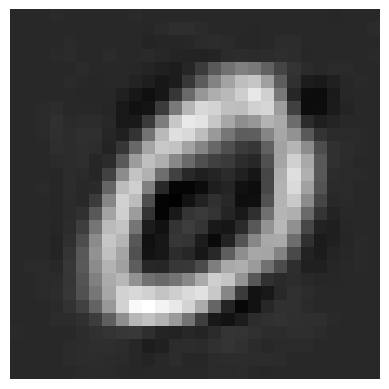

In [152]:
import matplotlib.pyplot as plt

# display decoded image
image = decoded.reshape(28, 28).to("cpu").detach().numpy()
plt.imshow(image, cmap='gray')
plt.axis('off')  # Hide axes
plt.show()

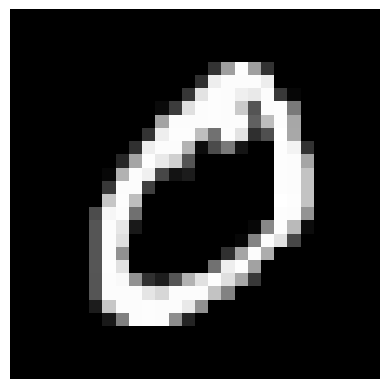

In [153]:
# display original image
plt.imshow(val_image.reshape(28, 28).numpy(), cmap='gray')
plt.axis('off')  # Hide axes
plt.show()